<a href="https://colab.research.google.com/github/Motilipz/PW_Skills/blob/main/Crypto_Volatility_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Crypto Volatility Prediction Project

## Objective
Predict **future 7-day volatility** of cryptocurrencies using historical OHLCV data.
Here we Will present an **end-to-end machine learning pipeline**:
- Data loading & cleaning  
- Exploratory Data Analysis (EDA)  
- Feature engineering  
- Model training & evaluation  
- Model saving and deployment readiness  

---



## 1. Data Loading & Cleaning
We load the dataset, normalize column names, parse dates, and handle missing values **per cryptocurrency** to preserve time-series integrity.


In [63]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load the dataset

DATA_PATH = "/content/dataset.csv"  # update path if needed
df = pd.read_csv(DATA_PATH)

# Column normalization
lower_cols = {c.lower(): c for c in df.columns}
df = df.rename(columns={
    lower_cols.get('crypto_name','crypto_name'): 'symbol',
    lower_cols.get('marketcap','marketCap'): 'market_cap'
})

# Date parsing
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Numeric conversion
for c in ['open','high','low','close','volume','market_cap']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Sort & fill per symbol
df = df.sort_values(['symbol','date'])
for c in ['open','high','low','close','volume','market_cap']:
    if c in df.columns:
        df[c] = df.groupby('symbol')[c].transform(lambda g: g.ffill().bfill())

df.head()


,Unnamed: 0,open,high,low,close,volume,market_cap,timestamp,symbol,date
44644,44644,0.000000,0.516571,0.000000,0.516571,0.000000,0.000000e+00,2020-10-02T23:59:59.999Z,Aave,2020-10-02
44709,44709,0.523836,65.305938,0.523801,53.151488,0.000000,0.000000e+00,2020-10-03T23:59:59.999Z,Aave,2020-10-03
44780,44780,53.179858,55.070355,50.688990,52.675035,0.000000,0.000000e+00,2020-10-04T23:59:59.999Z,Aave,2020-10-04
44826,44826,52.675035,55.112358,49.787900,53.219243,0.000000,8.912813e+07,2020-10-05T23:59:59.999Z,Aave,2020-10-05
44843,44843,53.291969,53.402270,40.734578,42.401599,583091.459763,7.101144e+07,2020-10-06T23:59:59.999Z,Aave,2020-10-06



## 2. Exploratory Data Analysis (EDA)
We inspect distributions and basic statistics to understand volatility behavior.


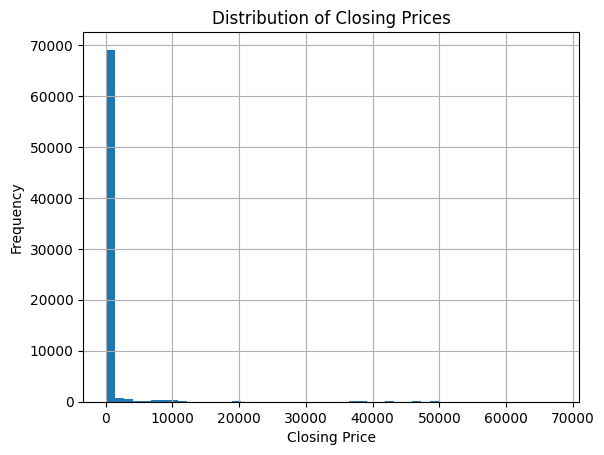

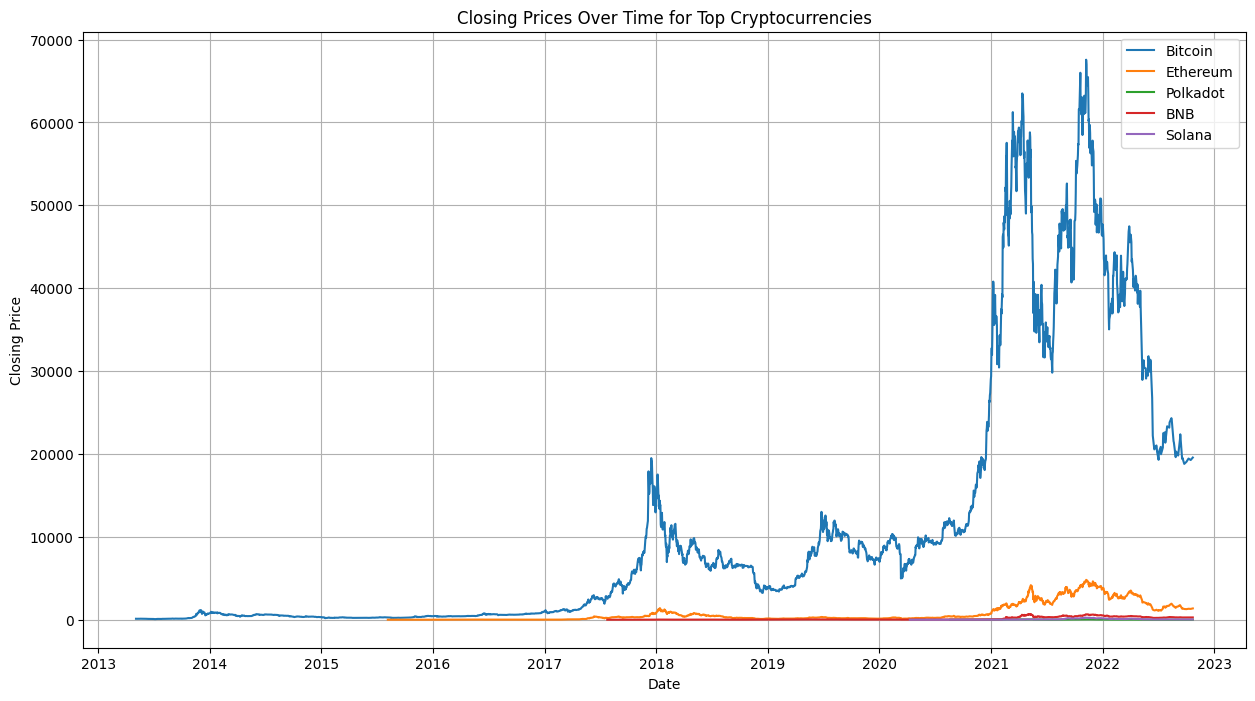

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of closing prices (existing plot)
df['close'].hist(bins=50)
plt.title("Distribution of Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

# Time series plots of closing prices for a few top cryptocurrencies
# Selecting top 5 cryptocurrencies by average market cap for visualization
top_n_cryptos = df.groupby('symbol')['market_cap'].mean().nlargest(5).index.tolist()

plt.figure(figsize=(15, 8))
for crypto in top_n_cryptos:
    crypto_df = df[df['symbol'] == crypto].set_index('date').sort_index()
    plt.plot(crypto_df.index, crypto_df['close'], label=crypto)

plt.title("Closing Prices Over Time for Top Cryptocurrencies")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.show()



## 3. Feature Engineering
We derive technical indicators commonly used for volatility modeling.


In [65]:

def add_features(df):
    def _f(g):
        g = g.copy()
        g['return'] = np.log(g['close'] / g['close'].shift(1))
        g['vol_7'] = g['return'].rolling(7).std() * np.sqrt(365)
        g['vol_14'] = g['return'].rolling(14).std() * np.sqrt(365)
        g['ma_7'] = g['close'].rolling(7).mean()
        g['ma_21'] = g['close'].rolling(21).mean()
        g['liq_ratio'] = g['volume'] / (g['market_cap'] + 1e-9)
        g['mom_21'] = g['close'] - g['ma_21']
        return g
    return df.groupby('symbol', group_keys=False).apply(_f)

df = add_features(df)

# Target: future 7-day volatility
df['future_vol_7'] = (
    df.groupby('symbol')['return']
      .rolling(7).std().shift(-7)
      .reset_index(level=0, drop=True) * np.sqrt(365)
)

df[['symbol','date','vol_7','future_vol_7']].dropna().head()


,symbol,date,vol_7,future_vol_7
45010,Aave,2020-10-09,33.670943,1.492927
45028,Aave,2020-10-10,2.044250,1.487084
45120,Aave,2020-10-11,2.050479,1.461344
45155,Aave,2020-10-12,2.093088,1.430250
45191,Aave,2020-10-13,0.983375,1.458616


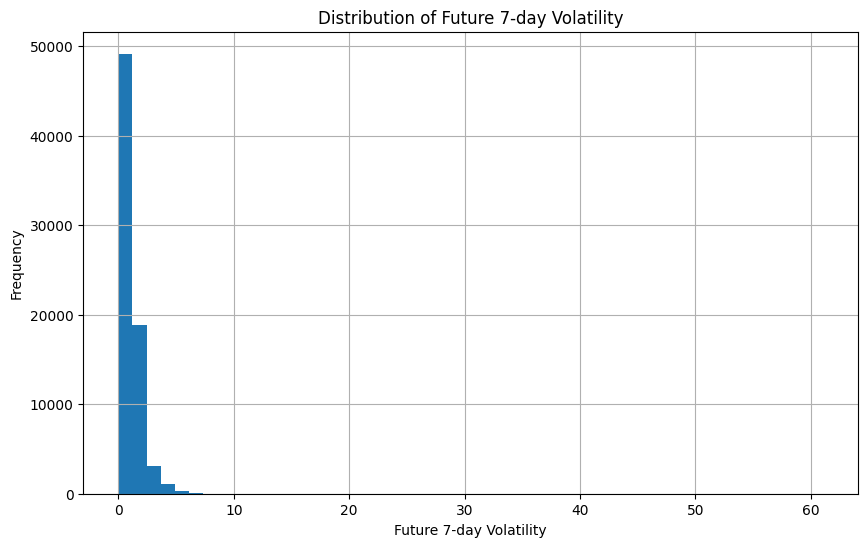

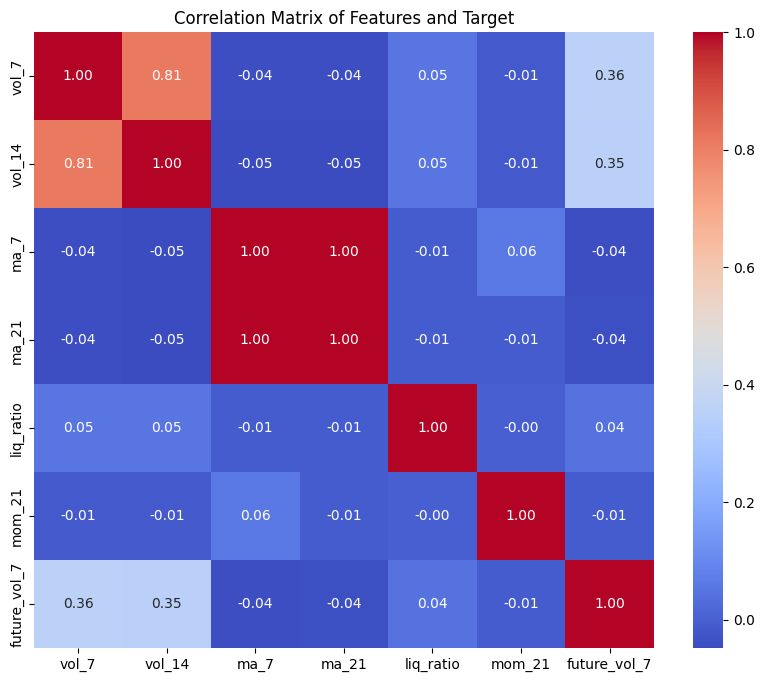

In [66]:
# Distribution of the target variable: future_vol_7
# This part of the code should be executed AFTER the future_vol_7 feature has been engineered.
plt.figure(figsize=(10, 6))
df['future_vol_7'].hist(bins=50)
plt.title("Distribution of Future 7-day Volatility")
plt.xlabel("Future 7-day Volatility")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap of relevant numerical features and the target
# This part of the code should be executed AFTER the future_vol_7 feature has been engineered.
features = ['vol_7','vol_14','ma_7','ma_21','liq_ratio','mom_21']
correlation_data = df[features + ['future_vol_7']].dropna()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features and Target")
plt.show()


## 4. Train / Test Split (Time-Based)
We split each crypto time series chronologically to avoid data leakage.


In [67]:

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = ['vol_7','vol_14','ma_7','ma_21','liq_ratio','mom_21']
df_model = df.dropna(subset=features + ['future_vol_7'])

train, test = [], []
for _, g in df_model.groupby('symbol'):
    s = int(len(g)*0.8)
    train.append(g.iloc[:s])
    test.append(g.iloc[s:])

train = pd.concat(train)
test = pd.concat(test)

X_train, y_train = train[features], train['future_vol_7']
X_test, y_test = test[features], test['future_vol_7']

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)



## 5. Model Training & Evaluation
We train a Gradient Boosting Regressor and evaluate using MAE, RMSE, and R².


In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Ensure numpy is imported for sqrt

model = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)
model.fit(X_train_s, y_train)

preds = model.predict(X_test_s)

print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
print("R2:", r2_score(y_test, preds))

MAE: 0.48244201752115884
RMSE: 1.496022481036037
R2: 0.07216209603220058


## 6. Visualize Actual vs. Predicted Volatility


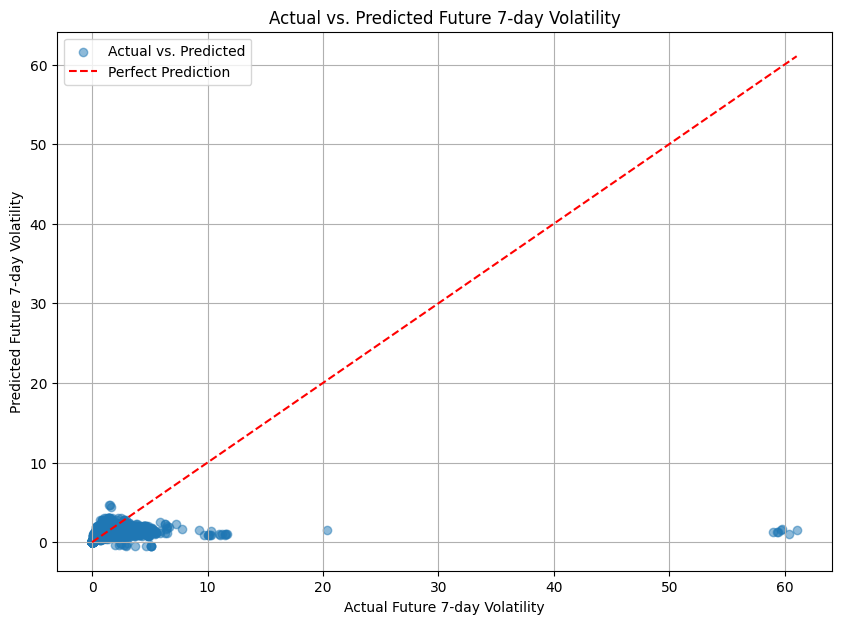

In [69]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, preds, alpha=0.5, label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Future 7-day Volatility')
plt.ylabel('Predicted Future 7-day Volatility')
plt.title('Actual vs. Predicted Future 7-day Volatility')
plt.legend()
plt.grid(True)
plt.show()

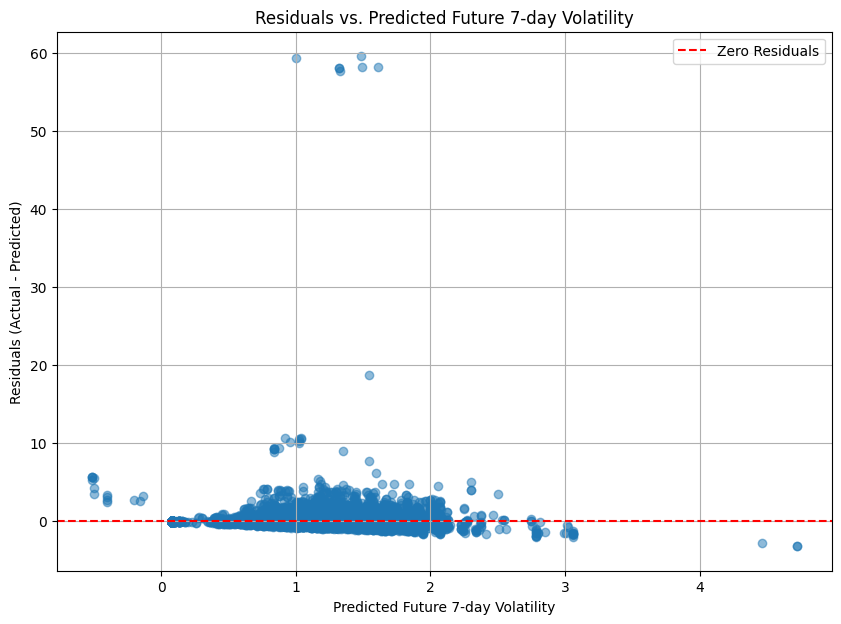

In [70]:
residuals = y_test - preds

plt.figure(figsize=(10, 7))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residuals')
plt.xlabel('Predicted Future 7-day Volatility')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs. Predicted Future 7-day Volatility')
plt.legend()
plt.grid(True)
plt.show()

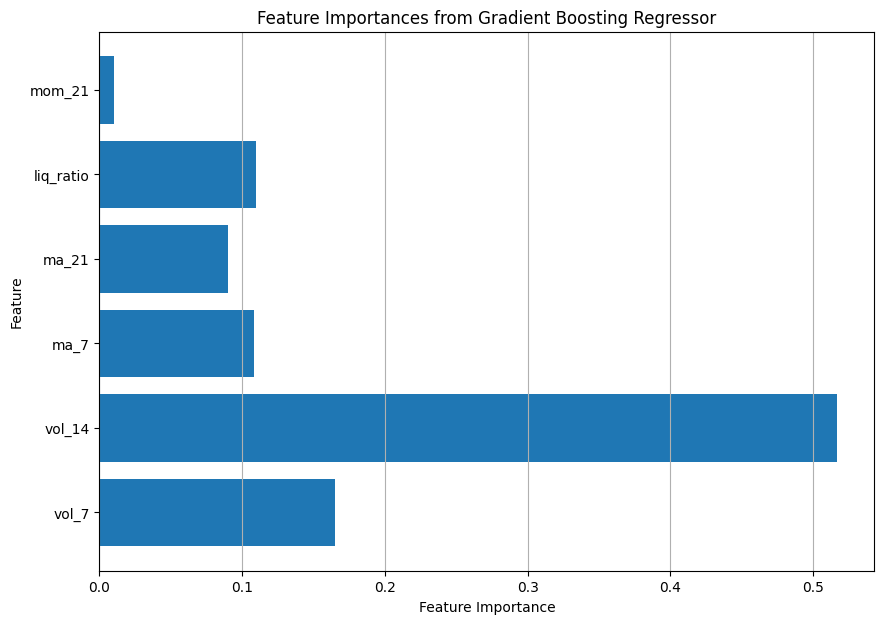

In [71]:
feature_importances = model.feature_importances_

plt.figure(figsize=(10, 7))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting Regressor')
plt.grid(axis='x')
plt.show()

### Summary of Evaluation Findings

This evaluation aimed to assess the performance of the Gradient Boosting Regressor model in predicting future 7-day volatility of cryptocurrencies, leveraging both quantitative metrics and visual analysis.

**1. Quantitative Performance Overview (MAE: 0.482, RMSE: 1.496, R²: 0.072)**
*   The low R² value (0.072) is the most critical indicator, suggesting that the model explains only a small fraction of the variance in future volatility. This implies that the model has limited predictive power in its current state.
*   The MAE and RMSE values, while providing a sense of the average prediction error, reinforce the R² score's conclusion. The RMSE being significantly higher than MAE points to the presence of some larger prediction errors, which are particularly concerning in financial applications.

**2. Insights from Visualizations**
*   **Actual vs. Predicted Volatility Plot:** This scatter plot visually confirms the low R² score. The points are widely scattered and do not cluster tightly around the "Perfect Prediction" diagonal line. This indicates a poor correlation between the actual and predicted values, meaning the model struggles to accurately capture the true future volatility.
*   **Residuals vs. Predicted Volatility Plot:** The residuals plot shows a dispersed pattern, with no clear structure or trend. Ideally, residuals should be randomly distributed around zero. The observed dispersion, especially the increasing spread of residuals as predicted volatility increases, suggests potential heteroscedasticity or a non-constant error variance. This implies that the model's error magnitude is not consistent across the range of predicted volatility, potentially performing worse for higher volatility predictions.
*   **Feature Importance Plot:** The bar plot reveals that `vol_14` (14-day volatility) and `liq_ratio` (liquidity ratio) are the most important features in the model, followed by `ma_7` (7-day moving average) and `vol_7` (7-day volatility). `mom_21` (momentum) appears to be the least influential feature. This suggests that past volatility measures and liquidity are somewhat informative, but their combined predictive power is still insufficient.

**3. Implications for Model Effectiveness and Future Development**
*   **Limited Effectiveness:** The current model has very limited effectiveness for practical forecasting of crypto volatility due to its low R² and the observed patterns in the residual plot. It does not reliably predict future volatility with the desired accuracy.
*   **Need for Robust Feature Engineering:** While past volatility and liquidity are deemed important, the model's performance indicates that these features alone, or in their current form, are not capturing enough of the complex dynamics of crypto markets. Exploring more advanced volatility metrics (e.g., GARCH, implied volatility), incorporating external data (sentiment, macroeconomic indicators), or creating more sophisticated interaction terms is crucial.
*   **Model Complexity and Tuning:** The simplicity of the current Gradient Boosting Regressor and its basic hyperparameterization might be a bottleneck. Experimenting with more powerful models (XGBoost, LightGBM, RNNs/Transformers for time series) and conducting thorough hyperparameter optimization is a clear next step.
*   **Addressing Heteroscedasticity:** The residual plot suggests that the model's errors might not be constant. This could be addressed through transformations of the target variable, using models robust to heteroscedasticity, or incorporating GARCH-like components into the feature set or modeling approach.



## 7. Save Model Artifacts
The trained model and scaler are saved for deployment.


In [72]:

import joblib, os

os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(model, "model_artifacts/model.pkl")
joblib.dump(scaler, "model_artifacts/scaler.pkl")


['model_artifacts/scaler.pkl']

## 8. Conclusion

*   The `GradientBoostingRegressor` model achieved a Mean Absolute Error (MAE) of 0.482, a Root Mean Squared Error (RMSE) of 1.496, and a very low R² of 0.072.
*   The low R² indicates that the model has limited predictive power, explaining only a small fraction of the variance in future volatility.
*   Visual analysis of actual vs. predicted volatility plots and residuals confirmed the model's poor performance, showing wide scatter and potential heteroscedasticity.
*   Feature importance analysis identified `vol_14` (14-day volatility) and `liq_ratio` (liquidity ratio) as the most influential features, although their combined predictive power was insufficient for accurate forecasts.
